In [74]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os.path as osp

from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from tqdm import tqdm
from copy import deepcopy

In [75]:
with open("ml-1m/ratings.dat", "r") as file :
    ratings = file.readlines()

In [76]:
def load_ratings(path, num_users, num_items) :

    fp = open(osp.join(path, "ratings.dat"))
    ratings = np.zeros((num_users,num_items))
    mask_ratings = np.zeros((num_users, num_items))

    lines = fp.readlines()
    for line in lines:
        user, item, rating, _ = line.split("::")
        user_idx = int(user) - 1
        item_idx = int(item) - 1
        ratings[user_idx, item_idx] = int(rating)
        mask_ratings[user_idx, item_idx] = 1
    
    return ratings, mask_ratings

In [77]:
class AutoRec(nn.Module) :
    def __init__(self, d, k, dropout_rate) :
        super().__init__()
        self.encoder = nn.Linear(d,k)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.batch_norm = nn.BatchNorm1d(k)  # Added a  normalization layer
        self.decoder = nn.Linear(k,d)

    def forward(self, x):
        encoded = torch.sigmoid(self.encoder(x))
        encoded = self.dropout(encoded)
        encoded = self.batch_norm(encoded)
        decoded = self.decoder(encoded)
        return decoded
    
def get_mask(ratings):
    mask = ~torch.isnan(ratings) 
    ratings = torch.nan_to_num(ratings, nan=0.0)
    return ratings, mask.float()

def compute_rmse(pred, true, mask):
    assert pred.shape == true.shape
    loss = torch.sum(((pred - true) ** 2) * mask) / torch.sum(mask)
    return torch.sqrt(loss)

def compute_mse(pred, true, mask) :
    loss = torch.sum(((pred - true) ** 2) * mask) / torch.sum(mask)
    return loss

def adjust_outliers(tensor, low_threshold, high_treshold) :
    tensor[tensor>high_treshold] = high_treshold
    tensor[tensor<low_threshold] = low_threshold
    return tensor

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.constant_(m.bias, 0)


## Training

### Pre-processing

In [78]:
# Split the matrix 90/10 into train matrix and test matrices (with both having the same distribution of ratings)
def split_matrix(matrix, ratio=0.9):
    new_train = np.copy(matrix)
    new_test = np.full(matrix.shape, np.nan)
    
    for i in range(matrix.shape[0]):
        ratings = np.where(~np.isnan(matrix[i]))[0]
        if len(ratings) > 2:
            np.random.shuffle(ratings)
            split_index = int(ratio * len(ratings))
            new_test[i, ratings[split_index:]] = matrix[i, ratings[split_index:]]
            new_train[i, ratings[split_index:]] = np.nan
            
    return new_train, new_test

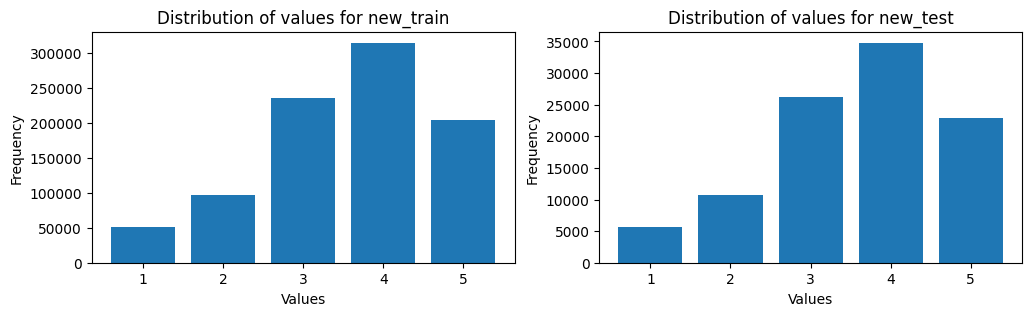

In [79]:
# Make sure the distribution of ratings is the same for both train and test matrices (was not done in the original paper, 
# they used random splitting and reported average RMSE on multiple experiments instead)
num_users = 6040
num_movies = 3952
ratings_full, mask_R = load_ratings("ml-1m/", num_users, num_movies)

new_train, new_test = split_matrix(ratings_full)

new_train_values, new_train_counts = np.unique(new_train, return_counts=True)
new_test_values, new_test_counts = np.unique(new_test, return_counts=True)

fig, ax = plt.subplots(1,2, figsize=(12,3))

ax[0].bar(new_train_values[1:], new_train_counts[1:])
ax[0].set_xlabel("Values")
ax[0].set_ylabel("Frequency")
ax[0].set_title("Distribution of values for new_train")

ax[1].bar(new_test_values[1:], new_test_counts[1:])
ax[1].set_xlabel("Values")
ax[1].set_ylabel("Frequency")
ax[1].set_title("Distribution of values for new_test")

plt.show()

# print(f"Minimum amount of ratings per user for new test: {np.min(np.sum(~np.isnan(new_test), axis=1))}")
# print(f"Minimum amount of ratings per movie for new test: {np.min(np.sum(~np.isnan(new_test), axis=0))}")
# print(f"Minimum amount of ratings per user for new train: {np.min(np.sum(~np.isnan(new_train), axis=1))}")
# print(f"Minimum amount of ratings per movie for new train: {np.min(np.sum(~np.isnan(new_test), axis=0))}")

### Training 

In [80]:
num_users = 6040
num_movies = 3952
ratings_full, mask_R = load_ratings("ml-1m/", num_users, num_movies)
device = "cuda" if torch.cuda.is_available() else "cpu"

user_based = False
if user_based : # User-based training
    input_dim = num_movies
else : # Item-based training
    input_dim = num_users
    ratings_full = ratings_full.T

# Get training and testing matrices
new_train_ratings, new_test_ratings = split_matrix(ratings_full, ratio=0.90)
new_train_ratings, new_test_ratings = torch.Tensor(new_train_ratings), torch.Tensor(new_test_ratings)

new_train_ratings = new_train_ratings.masked_fill(new_train_ratings==0, float('nan'))
new_test_ratings = new_test_ratings.masked_fill(new_test_ratings==0, float('nan'))

new_train_ratings, new_train_mask = get_mask(new_train_ratings)
new_test_ratings, new_test_mask = get_mask(new_test_ratings)


Hidden_space_dimension: 500. Epoch 250, RMSE on Training data: 0.7328, Validation RMSE: 0.8333, Learning Rate: 2.13623046875e-07: 100%|██████████| 250/250 [00:46<00:00,  5.42it/s]


Saved weights at epoch : 204 and got for Validaiton/Test rmse : 0.8331267237663269


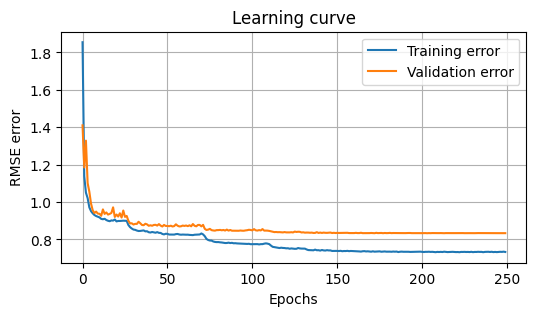

In [81]:
# Training

losses = {}
all_loss_values = {} # To try different hidden space dimension

nb_epochs = 250
batch_size = 512

best_rmse = 1e5
best_model = None
early_stopping = True

train_dataset = TensorDataset(new_train_ratings, new_train_mask)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)

for hidden_space_dimension in [500] :
    model = AutoRec(input_dim, hidden_space_dimension, dropout_rate=0.4)
    model.apply(init_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.007, weight_decay=8e-4) 
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                               mode='min',
                               factor=0.5, 
                               patience=5)
    model = model.to(device)
    pbar = tqdm(range(nb_epochs))
    
    loss_values = []
    
    # Main training loop
    for epoch in pbar:
        model.train()
        epoch_loss = 0
        for batch_ratings, batch_mask in train_loader:
            batch_ratings = batch_ratings.to(device)
            batch_mask = batch_mask.to(device)
            optimizer.zero_grad()
            output_matrix = model(batch_ratings)
            loss = compute_mse(output_matrix, batch_ratings, batch_mask)
            loss.backward()
            optimizer.step()

            output_matrix = adjust_outliers(output_matrix, 1, 5)
            epoch_loss += compute_rmse(output_matrix, batch_ratings.to(device), batch_mask.to(device)).item()
            
        epoch_loss /= len(train_loader)
        scheduler.step(epoch_loss)

        loss_values.append(epoch_loss)

        # Early stopping using validation data
        if early_stopping :
            model.eval()
            
            with torch.no_grad() :
                predictions = model(new_train_ratings.to(device))
                predictions = adjust_outliers(predictions, 1, 5)
                test_loss = compute_rmse(predictions, new_test_ratings.to(device), new_test_mask.to(device))
                current_lr = optimizer.param_groups[0]['lr']
                pbar.set_description(
                    f"Hidden_space_dimension: {hidden_space_dimension}. Epoch {epoch + 1}, "
                    f"RMSE on Training data: {epoch_loss:.4f}, "
                    f"Validation RMSE: {test_loss.item():.4f}, "
                    f"Learning Rate: {current_lr}"
                )
                if test_loss.item() < best_rmse :
                    best_rmse = test_loss
                    best_model = deepcopy(model)
                    torch.save(model.state_dict(), f"best_model_hsd{hidden_space_dimension}.pth")
                    saved_weights_epoch = epoch + 1

        losses.setdefault("training", []).append(epoch_loss)
        losses.setdefault("validation", []).append(test_loss.item())

print(f"Saved weights at epoch : {saved_weights_epoch} and got for Validaiton/Test rmse : {best_rmse}")

plt.figure(figsize=(6, 3))
# for hidden_space_dimension, loss_values in all_loss_values.items():
#     plt.plot(loss_values, label=f'Hidden Space: {hidden_space_dimension}')
plt.plot(list(range(nb_epochs)), losses['training'], label = "Training error")
plt.plot(list(range(nb_epochs)), losses['validation'], label = "Validation error")
plt.title('Learning curve')
plt.xlabel('Epochs')
plt.ylabel('RMSE error')
plt.legend()
plt.grid()
plt.show()

## Evaluation

In [ ]:
# Evaluation

hidden_space_dimension = 500
model = AutoRec(input_dim, hidden_space_dimension, dropout_rate=0.4).to(device)
model.eval()
model.load_state_dict(torch.load("best_model_hsd500.pth", weights_only=True))
            
with torch.no_grad() :
    predictions = model(new_train_ratings.to(device))
    predictions = adjust_outliers(predictions, 1, 5)
    test_loss = compute_rmse(predictions, new_test_ratings.to(device), new_test_mask.to(device))
print(test_loss.item())


0.8321294784545898
